# Limpieza de *outliers* o valores atípicos

La limpieza de *outliers* o valores atípicos es un proceso importante en el análisis de datos. Los *outliers* son valores que se desvían significativamente de los valores esperados o normales. Estos valores pueden ser el resultado de errores de medición, errores de transcripción, o simplemente valores que no son representativos de la población.

Aunque se pierdan registros, es importante eliminar dichos *outliers* para obtener resultados más precisos.

Muchas veces, el verdadero éxito de una estimación con modelos predictivos o *machine learning* es la tarea previa de limpieza de valores atípicos.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from scipy import stats

In [3]:
# Estilo de gráficos y paleta de colores
plt.style.use('default')
sns.set_palette("husl")

Aprovechamos que la propia librería scikit-learn dispone de datasets para su uso sin necesidad de importar ficheros

In [4]:
# Cargar el dataset de California Housing desde sklearn
housing = fetch_california_housing()
# Crear DataFrame con nombres de columnas
df = pd.DataFrame(housing.data, columns=housing.feature_names)
# Añadir variable objetivo (precio medio de la vivienda)
df['target'] = housing.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
# Para conocer lo que representa cada columna, mostramos la descripción textual del dataset
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [6]:
# Información de tipos de datos y nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Estadísticas descriptivas iniciales: Realizamos un análisis exploratorio inicial con las principales estadísticas descriptivas, fijandonos especialmente en los valores máximos (por ejemplo, viviendas con 34 dormitorios cuando la la media es de 1.09 dormitorios por vivienda)

In [7]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Creamos una función para visualizar outliers columna a columna con boxplots (librería matplotlib)

In [8]:
### Visualizamos los outliers usando boxplots
def plot_outliers(df, title=""):
    # Crear rejilla 3x3 de subgráficos
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle(title, fontsize=16)
    
    columns = df.columns
    for i, col in enumerate(columns):
        # Calcular posición en la rejilla
        row = i // 3
        col_idx = i % 3
        # Boxplot de la columna
        axes[row, col_idx].boxplot(df[col])
        axes[row, col_idx].set_title(col)
        axes[row, col_idx].tick_params(axis='x', rotation=45)
    
    # Ajustar diseño y mostrar
    plt.tight_layout()
    plt.show()

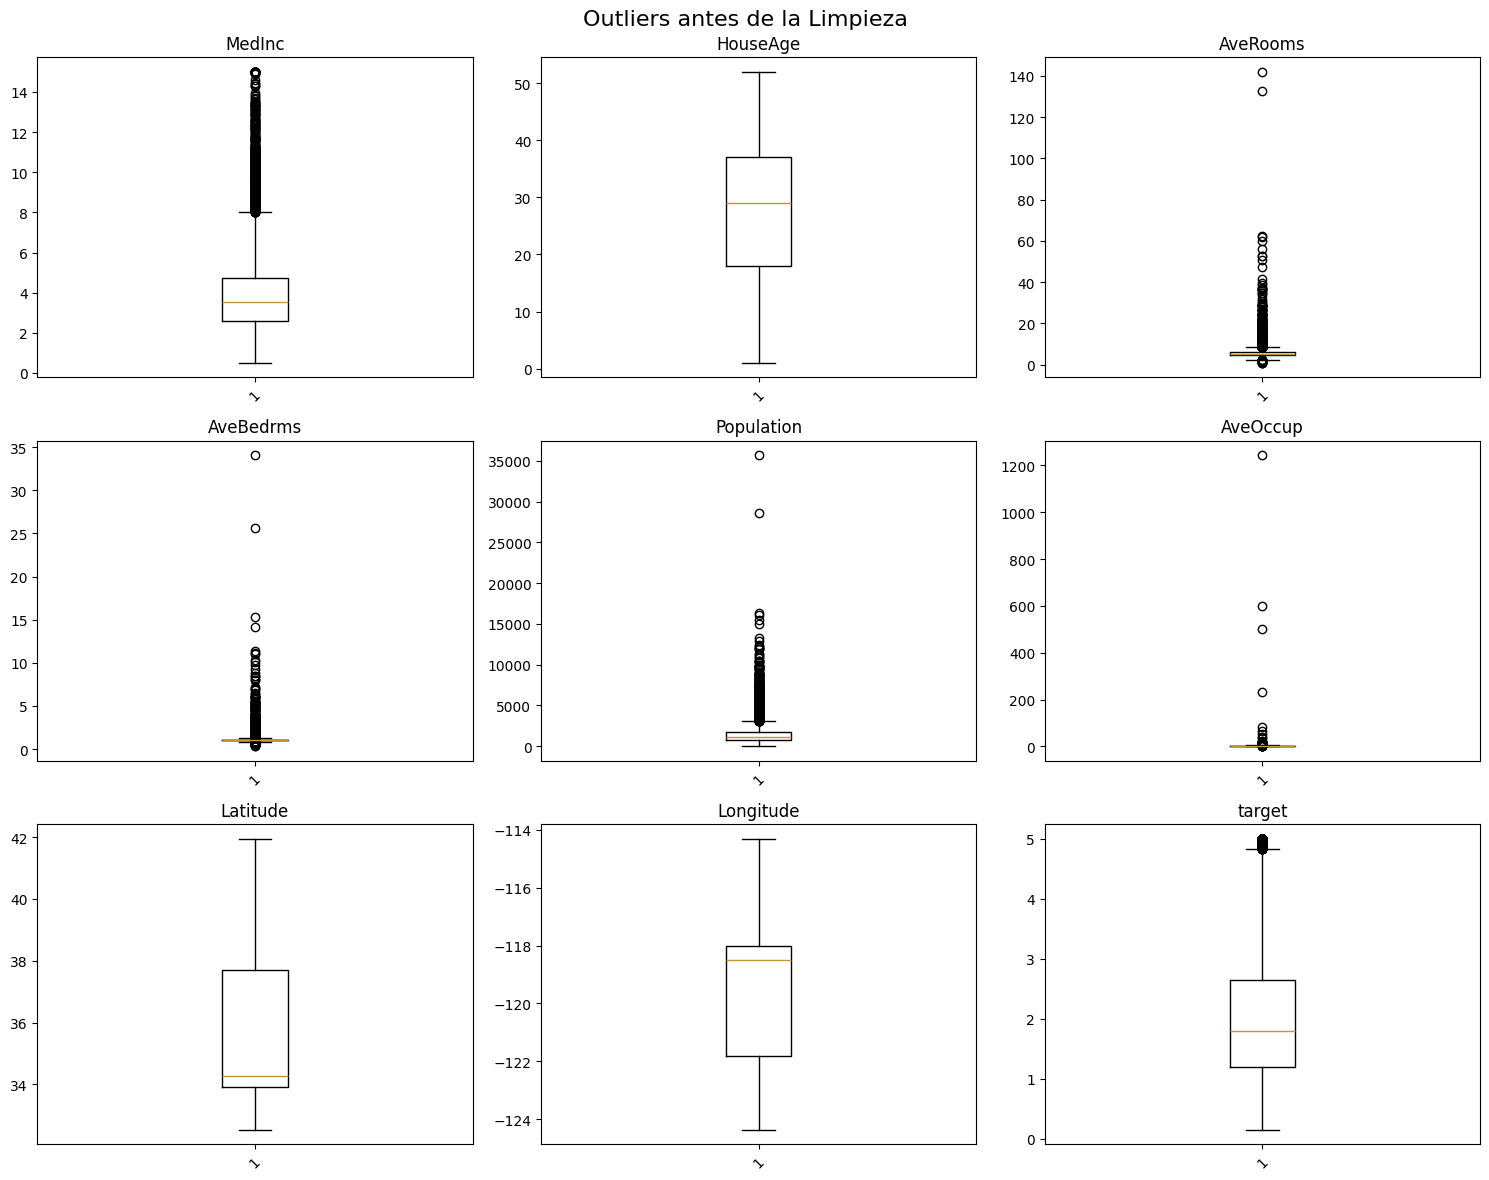

In [34]:
# Visualizar outliers iniciales (antes de limpiar)
plot_outliers(df, "Outliers antes de la Limpieza")

Definimos las funciones de limpieza:
- `detectar_outliers_iqr`: Detecta outliers usando el método `IQR` (rangos intercuartílicos)
- `detectar_outliers_zscore`: Detecta outliers usando `Z-score` (máscara por umbrales)

In [10]:
def detectar_outliers_iqr(series, multiplier=1.5):
    # Cuartiles y rango intercuartílico
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    # Límites inferior y superior
    limite_inf = Q1 - multiplier * IQR
    limite_sup = Q3 + multiplier * IQR
    # Máscara booleana de outliers
    return (series < limite_inf) | (series > limite_sup)

In [11]:
def detectar_outliers_zscore(series, umbral=3):
    # Cálculo de z-scores absolutos y máscara por umbral
    z_scores = np.abs(stats.zscore(series))
    return z_scores > umbral

### Limpieza específica basada en lógica de negocio

In [12]:
# Copia del DataFrame para limpiar sin alterar el original
df_cleaned = df.copy()
# Guardar nº de filas inicial
initial_rows = len(df_cleaned)

In [13]:
# Regla: precios medios > $500k como outliers
# Target > 5 (precio medio > $500,000)
outliers_target = df_cleaned['target'] > 5
print(f"Casas con precio > $500k: {outliers_target.sum()} registros")

Casas con precio > $500k: 965 registros


In [14]:
# Regla: promedio de habitaciones irreal
# AveRooms > 100
outliers_rooms = df_cleaned['AveRooms'] > 100
print(f"Casas con >100 habitaciones promedio: {outliers_rooms.sum()} registros")

Casas con >100 habitaciones promedio: 2 registros


In [15]:
# Regla: promedio de dormitorios irreal
# AveBedrms > 50 
outliers_bedrms = df_cleaned['AveBedrms'] > 50
print(f"Casas con >50 dormitorios promedio: {outliers_bedrms.sum()} registros")

Casas con >50 dormitorios promedio: 0 registros


In [16]:
# Regla: ocupación media muy alta
# AveOccup > 50 
outliers_occup = df_cleaned['AveOccup'] > 50
print(f"Bloques con ocupación >50 personas/casa: {outliers_occup.sum()} registros")

Bloques con ocupación >50 personas/casa: 7 registros


In [17]:
# Regla: población extremadamente alta por bloque
# Population >50000
outliers_pop = df_cleaned['Population'] > 50000
print(f"Bloques con población >50,000: {outliers_pop.sum()} registros")

Bloques con población >50,000: 0 registros


In [18]:
# Regla: edad de la vivienda negativa o >100 años
# HouseAge negativa o > 100 años
outliers_age = (df_cleaned['HouseAge'] < 0) | (df_cleaned['HouseAge'] > 100)
print(f"Casas con edad <0 o >100 años: {outliers_age.sum()} registros")

Casas con edad <0 o >100 años: 0 registros


### Combinación de máscaras de outliers por reglas de negocio

In [19]:
# Combinar todos los outliers lógicos
logical_outliers = (outliers_target | outliers_rooms | outliers_bedrms | 
                   outliers_occup | outliers_pop | outliers_age)

In [20]:
# Conteo de outliers por lógica de negocio
print(f"\nTotal de outliers por lógica de negocio: {logical_outliers.sum()}")


Total de outliers por lógica de negocio: 973


### Limpieza adicional con IQR

In [21]:
# DataFrame auxiliar para marcar outliers por IQR
# Detectar outliers estadísticos en variables numéricas clave
iqr_outliers = pd.DataFrame(index=df_cleaned.index)

In [22]:
# Marcar outliers por IQR para cada variable clave
for col in ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']:
    iqr_outliers[col] = detectar_outliers_iqr(df_cleaned[col])
    print(f"- {col}: {iqr_outliers[col].sum()} outliers detectados")

- MedInc: 681 outliers detectados
- HouseAge: 0 outliers detectados
- AveRooms: 511 outliers detectados
- AveBedrms: 1424 outliers detectados
- Population: 1196 outliers detectados
- AveOccup: 711 outliers detectados


Marcar registros con >= x variables extremas

In [23]:
# Considerar outlier si es extremo en múltiples variables
for i in range(4):
    multiple_outliers = (iqr_outliers.sum(axis=1) >= i)
    print(f'Registros con outliers en mas de {i} variables: {multiple_outliers.sum()}')

Registros con outliers en mas de 0 variables: 20640
Registros con outliers en mas de 1 variables: 3798
Registros con outliers en mas de 2 variables: 679
Registros con outliers en mas de 3 variables: 42


In [24]:
# Consideramos que con 2 o más variables atipicas es un outlier que debe eliminarse
multiple_outliers = (iqr_outliers.sum(axis=1) >= 2)
multiple_outliers.sum()

679

In [25]:
### Aplicamos la limpieza
# Unir outliers lógicos y estadísticos y filtrar
all_outliers = logical_outliers | multiple_outliers
df_cleaned = df_cleaned[~all_outliers].reset_index(drop=True)

In [26]:
print(f'df original: {len(df)} y df_cleaned {len(df_cleaned)}')

df original: 20640 y df_cleaned 19128


In [27]:
# Resumen de la depuración
print(f"Registros eliminados: {initial_rows - len(df_cleaned)}")
print(f"Porcentaje eliminado: {((initial_rows - len(df_cleaned)) / initial_rows * 100):.2f}%")
print(f"Dimensiones finales: {df_cleaned.shape}")

Registros eliminados: 1512
Porcentaje eliminado: 7.33%
Dimensiones finales: (19128, 9)


### Comparación de las estadísticas antes y después

In [28]:
# Estadísticas del dataset original (variables seleccionadas)
df[['target', 'AveRooms', 'AveBedrms', 'AveOccup', 'Population']].describe()

,target,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,2.068558,5.429000,1.096675,3.070655,1425.476744
std,1.153956,2.474173,0.473911,10.386050,1132.462122
min,0.149990,0.846154,0.333333,0.692308,3.000000
25%,1.196000,4.440716,1.006079,2.429741,787.000000
50%,1.797000,5.229129,1.048780,2.818116,1166.000000
75%,2.647250,6.052381,1.099526,3.282261,1725.000000
max,5.000010,141.909091,34.066667,1243.333333,35682.000000


In [29]:
# Estadísticas del dataset limpio (mismas variables)
df_cleaned[['target', 'AveRooms', 'AveBedrms', 'AveOccup', 'Population']].describe()

,target,AveRooms,AveBedrms,AveOccup,Population
count,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000
mean,1.927449,5.189416,1.061785,2.935468,1429.377196
std,0.974130,1.123154,0.110299,0.819692,1061.452127
min,0.149990,1.000000,0.333333,0.970588,5.000000
25%,1.167000,4.408305,1.005025,2.447562,806.000000
50%,1.745000,5.162897,1.047170,2.837330,1183.000000
75%,2.489000,5.927836,1.095613,3.296437,1738.000000
max,5.000000,10.352941,3.099338,33.952941,16305.000000


### Visualización de outliers después de limpiar

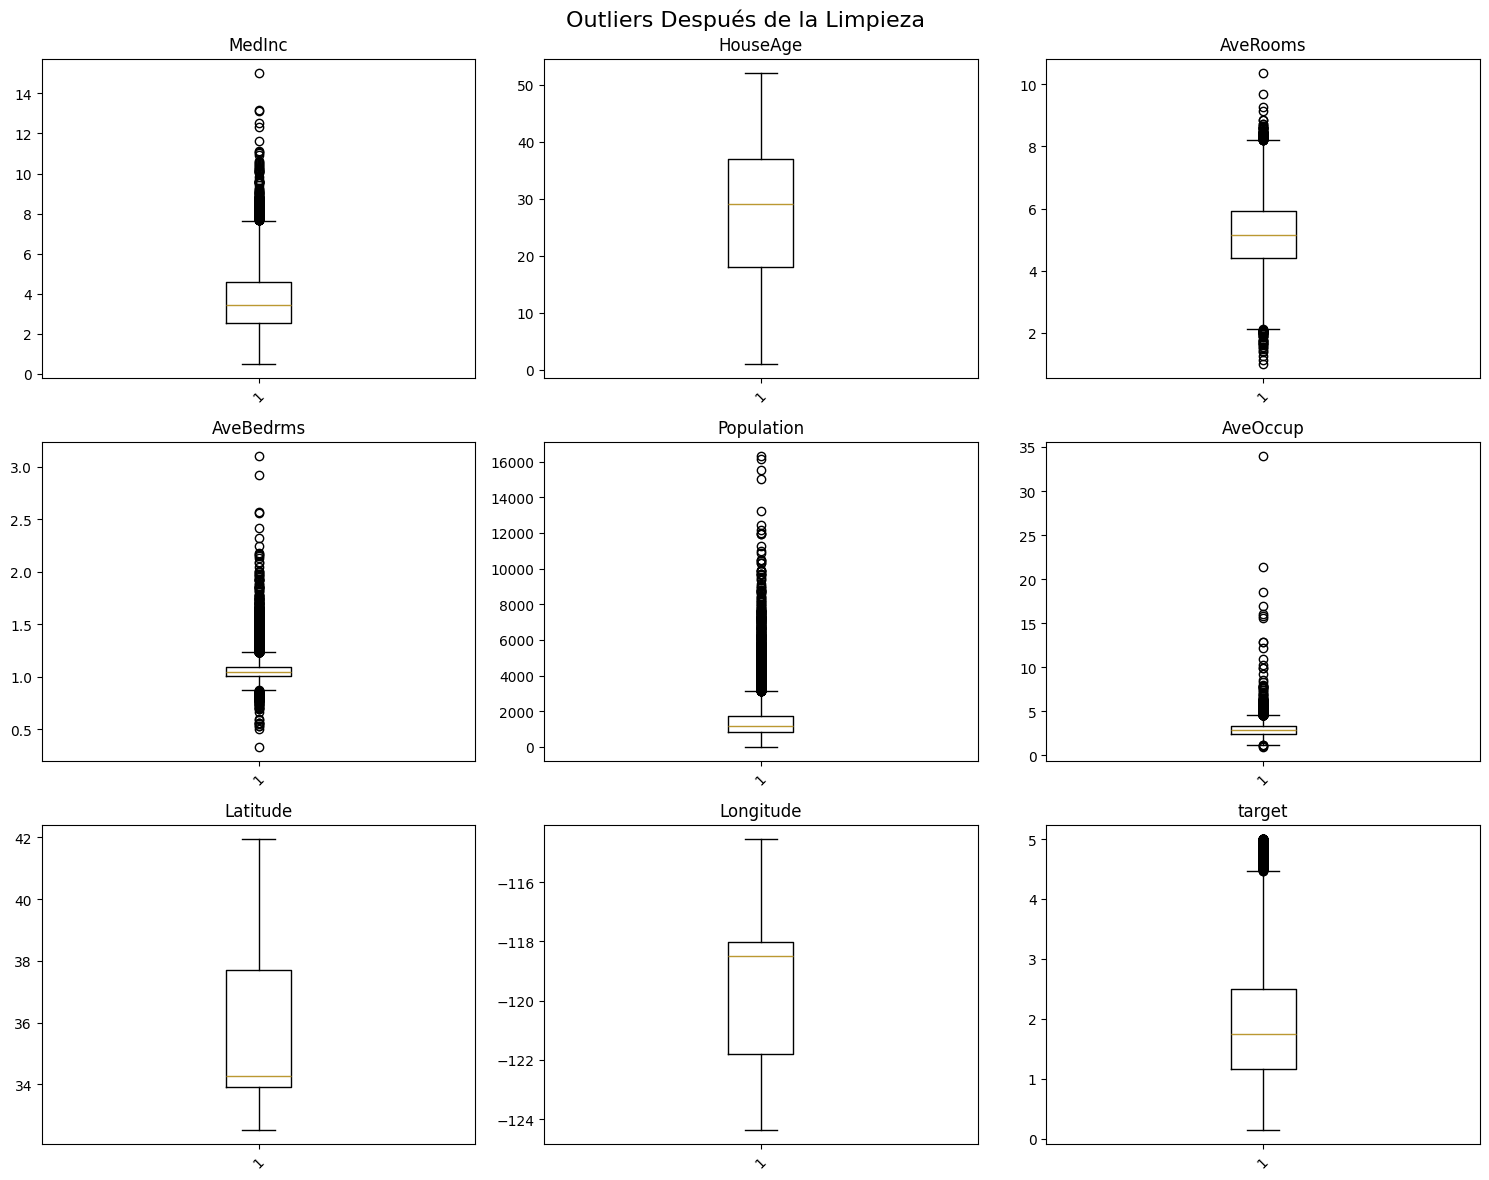

In [30]:
### Visualizamos los outliers después de la limpieza
plot_outliers(df_cleaned, "Outliers Después de la Limpieza")

### Analizamos las correlaciones

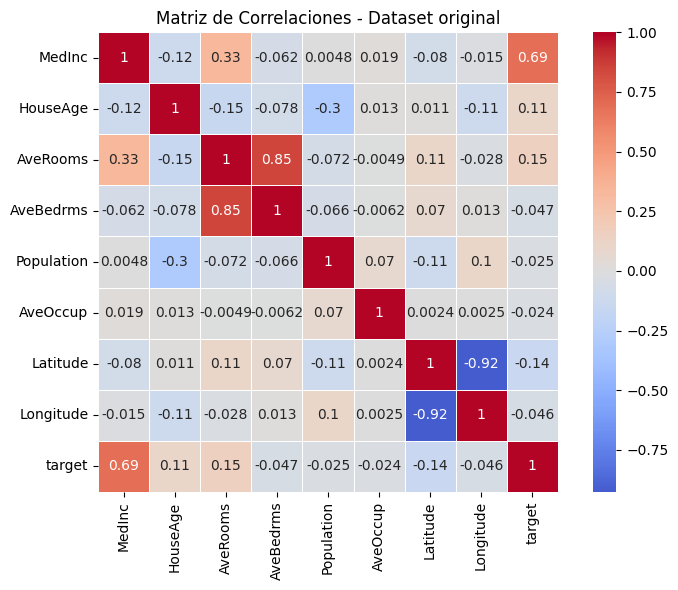

In [31]:
# Matriz de correlación y mapa de calor
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title("Matriz de Correlaciones - Dataset original")
plt.tight_layout()
plt.show()

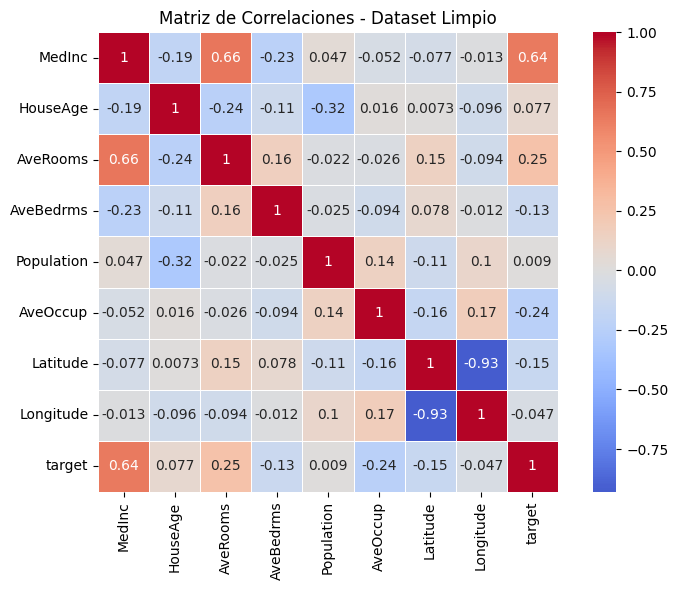

In [32]:
# Matriz de correlación y mapa de calor
correlation_matrix = df_cleaned.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title("Matriz de Correlaciones - Dataset Limpio")
plt.tight_layout()
plt.show()

In [33]:
# Guardar dataset limpio en formato Feather
df_cleaned.to_feather('../data/03_model_input/california_housing_clean.ftr')